In [1]:
import pandas as pd
import numpy as np

## Task

### Resources

In [2]:
# Fairness metrics
def CohenD(yobs, ypred, gmaj, gmin):
    ### Cohen-D
    SR_min = ypred[gmin==1].mean() # success rate minority
    SR_maj = ypred[gmaj==1].mean() # success rate majority
    
    STD_maj = np.sqrt(SR_maj * (1.0 - SR_maj))
    STD_min = np.sqrt(SR_min * (1.0 - SR_min))
    POOL_STD = STD_maj * ( sum(gmaj==1)/(sum(gmin==1) + sum(gmaj==1)) ) + STD_min * ( sum(gmin==1)/(sum(gmin==1) + sum(gmaj==1)) )
    
    return StatParity(yobs, ypred, gmaj, gmin)/POOL_STD

def DispImpact(yobs, ypred, gmaj, gmin):
    ### Disparate Impact (a.k.a. Adverse Impact Ratio)
    SR_min = ypred[gmin==1].mean() # success rate minority
    SR_maj = ypred[gmaj==1].mean() # success rate majority
    return SR_min/SR_maj

def StatParity(yobs, ypred, gmaj, gmin):
    ### Statistical Parity Difference
    SR_min = ypred[gmin==1].mean() # success rate minority
    SR_maj = ypred[gmaj==1].mean() # success rate majority
    return SR_min - SR_maj

def TwoSDRule(yobs, ypred, gmaj, gmin):
    ### 2-SD Rule
    SR_min = ypred[gmin==1].mean() # success rate minority
    SR_maj = ypred[gmaj==1].mean() # success rate majority
    SR_T = ypred.mean() # success rate total
    P_min = (gmin==1).mean() # minority proportion
    N = len(ypred)
    return (SR_min - SR_maj)/np.sqrt( (SR_T * (1.0 - SR_T))/(N * P_min * (1 - P_min)) )

def EqualOppDiff(yobs, ypred, gmaj, gmin):
    ### Equal Opportunity Difference
    TPR_maj = sum( (yobs[gmaj==1]==1) * (ypred[gmaj==1]==1) )/sum(yobs[gmaj==1]==1)
    TPR_min = sum( (yobs[gmin==1]==1) * (ypred[gmin==1]==1) )/sum(yobs[gmin==1]==1)
    return TPR_min - TPR_maj

def AvgOddsDiff(yobs, ypred, gmaj, gmin):
    ### Average Odds Difference
    return (EqualOppDiff(yobs==0, ypred==0, gmaj, gmin) + EqualOppDiff(yobs, ypred, gmaj, gmin))/2.0


def compute_model_metrics(yobs, model, Xobs, gmaj=None, gmin=None):
    # metrics
    from sklearn import metrics
    perf_metrics = {"Accuracy": metrics.accuracy_score, 
                    "Precision": metrics.precision_score, 
                    "Recall": metrics.recall_score,
                    "AUC": metrics.roc_auc_score, 
                    "F1-Score": metrics.f1_score, 
                    "Brier": metrics.brier_score_loss
                   }
    # fairness metrics
    fair_metrics = {"Cohen-D": CohenD,
                    "2-SD Rule": TwoSDRule,
                    "StatParity": StatParity,
                    "EqualOppDiff": EqualOppDiff,
                    "DispImpact": DispImpact,
                    "AvgOddsDiff": AvgOddsDiff
                   }
    
    # get predictions -- where you would start, after loading the data and model
    ypred_prob = model.predict_proba(Xobs).ravel()[1::2] # get probabilities
    ypred_class = model.predict(Xobs)
    
    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf in ["AUC", "Brier"]:
            metrics += [[pf, perf_metrics[pf](yobs, ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](yobs, ypred_class)]]
            
    if (gmaj is not None) and (gmin is not None):
        for ff in fair_metrics.keys():
            metrics += [[ff, fair_metrics[ff](yobs, ypred_class, gmaj, gmin)]]
    
    return pd.DataFrame(metrics, columns=["Metric", "Value"])

### Dataset

In [3]:
# get dataset
df = pd.read_csv("https://raw.githubusercontent.com/askoshiyama/mli-cohort3/master/german_credit.csv")
sex_ps = df["personal_status_sex"].str.split(":", n = 1, expand = True)
sex_ps.columns = ["gender", "personal_status"]
df.drop("personal_status_sex", axis=1, inplace=True)
df = pd.concat([df, sex_ps], axis=1)

# categorical variables
cat_variables = ['account_check_status', 'credit_history', 'purpose', 'savings', 'present_emp_since', 'gender', 'personal_status',
                'property', 'other_installment_plans', 'housing', 'job', 'telephone', "other_debtors", 'foreign_worker']

# other integer variables
int_variables = ['credits_this_bank', 'present_res_since', 'duration_in_month', 'people_under_maintenance', 
                 'installment_as_income_perc', 'age', 'credit_amount']

# target variable
output_variable = ["default"]

### Pre-processing
# Mapping categorical variables to one-hot encoding
df_cat = pd.DataFrame(index=df.index)

# one-hot encoding of categorical variables
from sklearn.preprocessing import OneHotEncoder

# I will do a loop for pedagogical reasons, but it is not entirely necessary
for cat in cat_variables:
    # one-hot encoding fitting
    one_hot_func = OneHotEncoder().fit(df[[cat]])
    
    # mapping
    cat_mapped = one_hot_func.transform(df[[cat]]).toarray()
    
    # storing
    for (k, cat_label) in enumerate(one_hot_func.categories_[0]):
        df_cat[cat + "_" + cat_label] = cat_mapped[:, k]

# bracketing integer variable - age
from sklearn.preprocessing import KBinsDiscretizer
kbin_func = KBinsDiscretizer(n_bins=3, encode='onehot', strategy='quantile').fit(df[["age"]])
df_age = pd.DataFrame(kbin_func.transform(df[["age"]]).toarray(), columns=["young", "adult", "senior"])

# consolidating a final dataset
df_final = pd.concat([df[int_variables], df_cat, df_age, df[output_variable]], axis=1)
X = pd.concat([df[int_variables], df_cat, df_age], axis=1)
y = df[output_variable].copy()

### Modelling

In [4]:
# set metrics
# performance metrics
gmaj = df_final[['gender_male ']]
gmin = df_final[['gender_female ']]

# train model
#from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.neural_network import MLPClassifier
#rf = RandomForestClassifier(n_estimators=10, random_state=10, class_weight="balanced")
#rf = MLPClassifier(random_state=10, solver="lbfgs")
rf = LogisticRegression(C=0.0025, random_state=10, class_weight="balanced", solver="lbfgs")
rf = rf.fit(X, y.values.ravel())

# compute metrics
compute_model_metrics(y.values.ravel(), rf, X, gmaj.values.ravel(), gmin.values.ravel())

,Metric,Value
0,Accuracy,0.677000
1,Precision,0.472289
2,Recall,0.653333
3,AUC,0.733633
4,F1-Score,0.548252
5,Brier,0.215226
6,Cohen-D,0.290594
7,2-SD Rule,4.211641
8,StatParity,0.141889
9,EqualOppDiff,0.184255


## Evaluation Component

### Bootstrap, Permutation and Noising Magic

### Bootstrap

In [7]:
def bootstrap_magic(X, y, model, n_samples, refit=False, gmaj=None, gmin=None):
    # pre-allocation
    np.random.seed(10)
    df_instances = pd.DataFrame(index=X.index, columns=["sample_" + str(x) for x in range(n_samples)])
    
    for s in range(n_samples):        
        # simple bootstrap
        idx = np.random.choice(X.index, X.shape[0])
        
        # left-out indices
        odx = np.array(list(set(X.index) - set(idx)))
        
        # train the model before evaluation?
        if refit: 
            model.fit(X.loc[idx], y.loc[idx].values.ravel())
        
        # get predictions to left-out
        #df_instances.loc[odx, "sample_" + str(s)] = model.predict(X.loc[odx])
        df_instances["sample_" + str(s)].loc[odx] = model.predict_proba(X.loc[odx]).ravel()[1::2]
        
        # evaluate model
        if (gmaj is not None) and (gmin is not None):
            df_metrics = compute_model_metrics(y.loc[odx].values.ravel(), model, X.loc[odx], 
                                               gmaj.loc[odx].values.ravel(), gmin.loc[odx].values.ravel())
        else:
            df_metrics = compute_model_metrics(y.loc[odx].values.ravel(), model, X.loc[odx])
            
        df_metrics["Sample"] = s
        if s is 0:
            df_all_metrics = df_metrics.copy()
        else:
            df_all_metrics = pd.concat([df_all_metrics, df_metrics.copy()], axis=0, ignore_index=True)

    return {"instances": df_instances, "metrics": df_all_metrics}

In [13]:
c = bootstrap_magic(X=X, y=y, model=rf, n_samples=100, refit=True, gmaj=gmaj, gmin=gmin)

C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the nu

In [39]:
c["instances"].mean(axis=1).head(), y.head()

(0    0.189986
 1    0.762169
 2    0.276358
 3    0.666406
 4    0.491180
 dtype: float64,    default
 0        0
 1        1
 2        0
 3        0
 4        1)

#### Instance importance - performance

In [14]:
(y.values.ravel() - c["instances"].mean(axis=1)).abs().sort_values(ascending=False).head(10)

616    0.821759
637    0.819602
134    0.797373
272    0.786848
285    0.770957
685    0.768356
130    0.766031
255    0.765603
137    0.763409
286    0.761691
dtype: float64

In [40]:
X.loc[(y.values.ravel() - c["instances"].mean(axis=1)).abs().sort_values(ascending=False).head(10).index] # do a lime for them

,credits_this_bank,present_res_since,duration_in_month,people_under_maintenance,installment_as_income_perc,age,credit_amount,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,...,telephone_none,"telephone_yes, registered under the customers name",other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,foreign_worker_no,foreign_worker_yes,young,adult,senior
616,1,2,60,1,2,27,9157,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
637,2,4,60,1,2,21,15653,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
134,1,4,60,1,2,21,10144,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
272,1,4,48,1,4,36,12169,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
285,1,1,47,1,1,35,10722,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
685,1,4,60,2,4,34,6527,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
130,1,2,48,1,1,24,8487,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
255,1,1,60,1,1,27,7418,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
137,1,3,12,1,4,66,766,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
286,1,3,48,2,4,26,4788,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


#### instance importance - fairness - minority group

In [16]:
(y.values.ravel() - c["instances"].mean(axis=1)).abs()[gmin.values.ravel()==1].sort_values(ascending=False).head(10)

134    0.797373
285    0.770957
130    0.766031
945    0.751991
186    0.721157
667    0.708941
141    0.694622
735    0.693659
70     0.652206
73     0.651332
dtype: float64

In [41]:
X.loc[(y.values.ravel() - c["instances"].mean(axis=1)).abs()[
    gmin.values.ravel()==1].sort_values(ascending=False).head(10).index] # do a lime for them

,credits_this_bank,present_res_since,duration_in_month,people_under_maintenance,installment_as_income_perc,age,credit_amount,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,...,telephone_none,"telephone_yes, registered under the customers name",other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,foreign_worker_no,foreign_worker_yes,young,adult,senior
134,1,4,60,1,2,21,10144,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
285,1,1,47,1,1,35,10722,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
130,1,2,48,1,1,24,8487,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
945,2,1,48,1,1,30,8358,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
186,1,4,9,2,2,74,5129,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
667,1,1,48,1,1,27,3609,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
141,1,1,36,1,4,30,4795,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
735,1,2,36,1,3,29,3990,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
70,1,2,36,1,1,30,8133,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
73,2,1,42,1,2,41,5954,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


#### Avg case metrics + uncertainty

In [17]:
c["metrics"].pivot_table(values="Value", index="Metric", aggfunc=["mean", "median", "std", "mad"])

,mean,median,std,mad
,Value,Value,Value,Value
Metric,,,,
2-SD Rule,2.605503,2.607494,0.996064,0.783895
AUC,0.714922,0.714911,0.028628,0.023953
Accuracy,0.659724,0.658554,0.023292,0.018492
AvgOddsDiff,0.050447,0.053776,0.049911,0.039995
Brier,0.218847,0.218849,0.004979,0.004154
Cohen-D,0.298641,0.294556,0.117482,0.092617
DispImpact,1.400415,1.393361,0.173830,0.136454
EqualOppDiff,0.190220,0.196084,0.085724,0.069199


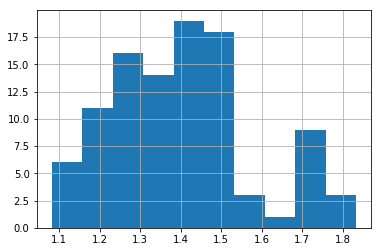

In [27]:
%matplotlib inline
c["metrics"].pivot_table(index="Sample", columns="Metric")["Value"]["DispImpact"].hist()

#### Worst/Best-case metrics

In [29]:
def q05(x):
    return np.quantile(x, q=.05)

def q95(x):
    return np.quantile(x, q=.95)

c["metrics"].pivot_table(values="Value", index="Metric", aggfunc=[q05, "median", "mean", q95])

,q05,median,mean,q95
,Value,Value,Value,Value
Metric,,,,
2-SD Rule,1.074700,2.607494,2.605503,4.524200
AUC,0.674611,0.714911,0.714922,0.756711
Accuracy,0.617957,0.658554,0.659724,0.695082
AvgOddsDiff,-0.034033,0.053776,0.050447,0.122865
Brier,0.211947,0.218849,0.218847,0.226852
Cohen-D,0.121826,0.294556,0.298641,0.528460
DispImpact,1.155727,1.393361,1.400415,1.733399
EqualOppDiff,0.039339,0.196084,0.190220,0.326601


### Permutation

In [43]:
def permutation_magic(X, y, model, n_repeats, refit=False, gmaj=None, gmin=None):
    # pre-allocation
    np.random.seed(10)
    
    for r in range(n_repeats):        
        # simple bootstrap
        idx = np.random.choice(X.index, X.shape[0])
        
        # left-out indices
        odx = np.array(list(set(X.index) - set(idx)))
        
        # train the model before evaluation?
        if refit: 
            model.fit(X.loc[idx], y.loc[idx].values.ravel())
        
        # baseline performance
        if (gmaj is not None) and (gmin is not None):
            df_baseline_metrics = compute_model_metrics(y.loc[odx].values.ravel(), model, X.loc[odx], 
                                                        gmaj.loc[odx].values.ravel(), gmin.loc[odx].values.ravel())
        else:
            df_baseline_metrics = compute_model_metrics(y.loc[odx].values.ravel(), model, X.loc[odx])
        
        # random permutation
        X_permuted = X.copy()
        X_features = X.columns
        shuffling_idx = np.arange(X.shape[0])
        for (j, col_idx) in enumerate(X_features):
            # shuffle
            np.random.shuffle(shuffling_idx)       
            if hasattr(X_permuted, "iloc"):
                col = X_permuted.iloc[shuffling_idx, j]
                col.index = X_permuted.index
                X_permuted.iloc[:, j] = col
            else:
                X_permuted[:, j] = X_permuted[shuffling_idx, col_idx]
            
            # compute performance
            if (gmaj is not None) and (gmin is not None):
                df_metrics = compute_model_metrics(y.loc[odx].values.ravel(), model, X_permuted.loc[odx], 
                                                   gmaj.loc[odx].values.ravel(), gmin.loc[odx].values.ravel())
            else:
                df_metrics = compute_model_metrics(y.loc[odx].values.ravel(), model, X_permuted.loc[odx])
        
            # store results
            df_metrics["Value"] = (df_baseline_metrics["Value"] - df_metrics["Value"])
            df_metrics["Variable"] = col_idx
            if j is 0:
                df_var_metrics = df_metrics.copy()
            else:
                df_var_metrics = pd.concat([df_var_metrics, df_metrics.copy()], axis=0, ignore_index=True)
        
        # store overall results
        df_var_metrics["Repeat"] = r
        if r is 0:
            df_all_metrics = df_var_metrics.copy()
        else:
            df_all_metrics = pd.concat([df_all_metrics, df_var_metrics.copy()], axis=0, ignore_index=True)
        
    return {"metrics": df_all_metrics}

#### Feature importance

In [44]:
c = permutation_magic(X=X, y=y, model=rf, n_repeats=10, refit=True, gmaj=gmaj, gmin=gmin)

C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [45]:
d=c["metrics"].pivot_table(index="Variable", columns="Metric", values="Value", aggfunc="mean")

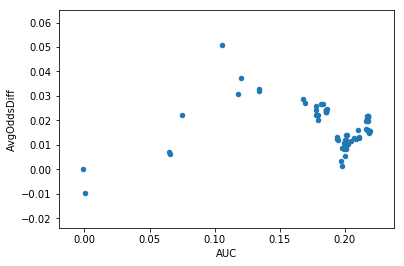

In [49]:
%matplotlib inline
d.plot(x="AUC", y="AvgOddsDiff", kind="scatter")

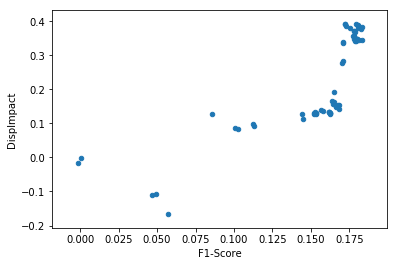

In [50]:
%matplotlib inline
d.plot(x="F1-Score", y="DispImpact", kind="scatter")

In [53]:
b=c["metrics"].pivot_table(index="Variable", columns="Metric", values="Value", aggfunc=["mean", "std"])
b["mean"]["AUC"].sort_values().tail(10)

Variable
other_debtors_co-applicant                                           0.217408
other_debtors_none                                                   0.217464
other_debtors_guarantor                                              0.217526
foreign_worker_yes                                                   0.217782
foreign_worker_no                                                    0.217801
job_unskilled - resident                                             0.217819
job_unemployed/ unskilled - non-resident                             0.218215
job_skilled employee / official                                      0.218284
job_management/ self-employed/ highly qualified employee/ officer    0.218851
housing_rent                                                         0.218967
Name: AUC, dtype: float64

In [54]:
b=c["metrics"].pivot_table(index="Variable", columns="Metric", values="Value", aggfunc=["mean", "std"])
b["mean"]["DispImpact"].sort_values().tail(10)

Variable
job_management/ self-employed/ highly qualified employee/ officer            0.376675
housing_own                                                                  0.379015
property_real estate                                                         0.380863
housing_rent                                                                 0.383205
personal_status_ single                                                      0.385860
job_unemployed/ unskilled - non-resident                                     0.386595
job_skilled employee / official                                              0.388791
job_unskilled - resident                                                     0.392038
property_if not A121 : building society savings agreement/ life insurance    0.392926
property_if not A121/A122 : car or other, not in attribute 6                 0.392991
Name: DispImpact, dtype: float64

### Noising

In [ ]:
# binary noise for one-hot encoded
# gaussian noise for everyone else

## Adversarial Attacks stuff

### Fast Grad Method

In [13]:
from art.classifiers import SklearnClassifier
from art.attacks.evasion import FastGradientMethod
pred_probs = rf.predict_proba(X).ravel()[1::2]

# generate some contrarian examples from
## borderline
# adversarial attack method
fgm = FastGradientMethod(SklearnClassifier(rf), 
                                       norm=np.inf, 
                                       eps=0.1, 
                                       eps_step=0.1, 
                                       targeted=True, 
                                       num_random_init=0, 
                                       batch_size=1, 
                                       minimal=True)
## get examples from the border
thresh = 0.5
pred_class = (pred_probs > thresh)
pred_close_border = np.abs(pred_probs.copy() - thresh)
bordertop10 = np.argsort(pred_close_border)[:10]
z_border_examples = fgm.generate(x=X.values[bordertop10, :], y=pred_class[bordertop10]==0)

## deep-in
# adversarial attack method
fgm = FastGradientMethod(SklearnClassifier(rf), 
                                       norm=np.inf, 
                                       eps=1.1, # we may need to learn this one
                                       eps_step=0.1, 
                                       targeted=True, 
                                       num_random_init=0, 
                                       batch_size=1, 
                                       minimal=True)

## get examples deep-in
pred_class = (pred_probs > thresh)
deepertop10 = np.argsort(pred_probs)[:10]
z_deeper_examples = fgm.generate(x=X.values[deepertop10, :], y=pred_class[deepertop10]==0)

In [6]:
rf.predict_proba(z_border_examples), rf.predict_proba(z_border_examples).ravel()[1::2] > thresh

(array([[0.54293126, 0.45706874],
        [0.45712888, 0.54287112],
        [0.45714134, 0.54285866],
        [0.4573298 , 0.5426702 ],
        [0.54261855, 0.45738145],
        [0.45765092, 0.54234908],
        [0.45810606, 0.54189394],
        [0.45810977, 0.54189023],
        [0.54169062, 0.45830938],
        [0.45840342, 0.54159658]]),
 array([False,  True,  True,  True, False,  True,  True,  True, False,
         True]))

In [7]:
rf.predict_proba(X.values[bordertop10, :]), rf.predict_proba(X.values[bordertop10, :]).ravel()[1::2] > thresh

(array([[0.49987954, 0.50012046],
        [0.50018104, 0.49981896],
        [0.50019359, 0.49980641],
        [0.50038345, 0.49961655],
        [0.49956453, 0.50043547],
        [0.5007069 , 0.4992931 ],
        [0.50116529, 0.49883471],
        [0.50116903, 0.49883097],
        [0.49862996, 0.50137004],
        [0.50146474, 0.49853526]]),
 array([ True, False, False, False,  True, False, False, False,  True,
        False]))

In [14]:
rf.predict_proba(z_deeper_examples), rf.predict_proba(z_deeper_examples).ravel()[1::2] > thresh

(array([[0.47386087, 0.52613913],
        [0.4642229 , 0.5357771 ],
        [0.49300141, 0.50699859],
        [0.47496718, 0.52503282],
        [0.47364898, 0.52635102],
        [0.46361377, 0.53638623],
        [0.49393663, 0.50606337],
        [0.46728739, 0.53271261],
        [0.49603915, 0.50396085],
        [0.49420325, 0.50579675]]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]))

In [15]:
rf.predict_proba(X.values[deepertop10, :]), rf.predict_proba(X.values[deepertop10, :]).ravel()[1::2] > thresh

(array([[0.83502332, 0.16497668],
        [0.82962248, 0.17037752],
        [0.82137345, 0.17862655],
        [0.81053062, 0.18946938],
        [0.80971739, 0.19028261],
        [0.80343041, 0.19656959],
        [0.79523771, 0.20476229],
        [0.77730131, 0.22269869],
        [0.76720066, 0.23279934],
        [0.76588636, 0.23411364]]),
 array([False, False, False, False, False, False, False, False, False,
        False]))

#### HopSkipJump

In [27]:
from art.classifiers import SklearnClassifier
from art.attacks.evasion import HopSkipJump
pred_probs = rf.predict_proba(X).ravel()[1::2]

# generate some contrarian examples from
## borderline
# adversarial attack method
hsj = HopSkipJump(SklearnClassifier(rf),
                  targeted=True, 
                  norm=2, 
                  max_iter=50, 
                  max_eval=10000, 
                  init_eval=100, 
                  init_size=100
                 )

## get examples from the border
thresh = 0.5
pred_class = (pred_probs > thresh)
pred_close_border = np.abs(pred_probs.copy() - thresh)
bordertop10 = np.argsort(pred_close_border)[:10]
z_border_examples = hsj.generate(x=X.values[bordertop10, :], y=pred_class[bordertop10]==0)

## deep-in
# adversarial attack method
hsj = HopSkipJump(SklearnClassifier(rf),
                  targeted=True, 
                  norm=2, 
                  max_iter=50, 
                  max_eval=10000, 
                  init_eval=100, 
                  init_size=100
                 )

## get examples deep-in
pred_class = (pred_probs > thresh)
deepertop10 = np.argsort(pred_probs)[:10]
z_deeper_examples = hsj.generate(x=X.values[deepertop10, :], y=pred_class[deepertop10]==0)

In [28]:
rf.predict_proba(z_border_examples), rf.predict_proba(z_border_examples).ravel()[1::2] > thresh

(array([[0.50001585, 0.49998415],
        [0.49997585, 0.50002415],
        [0.4999755 , 0.5000245 ],
        [0.49995014, 0.50004986],
        [0.50005743, 0.49994257],
        [0.49990802, 0.50009198],
        [0.49985451, 0.50014549],
        [0.49985273, 0.50014727],
        [0.50018024, 0.49981976],
        [0.49981582, 0.50018418]]),
 array([False,  True,  True,  True, False,  True,  True,  True, False,
         True]))

In [39]:
pd.DataFrame(z_border_examples, columns=X.columns)

,credits_this_bank,present_res_since,duration_in_month,people_under_maintenance,installment_as_income_perc,age,credit_amount,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,...,telephone_none,"telephone_yes, registered under the customers name",other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,foreign_worker_no,foreign_worker_yes,young,adult,senior
0,2.000224,4.000130,23.999817,0.999970,3.999541,31.000191,1934.999878,0.999669,0.000000,0.000000,...,0.000000,1.000296,0.000005,0.000109,1.000010,0.000099,0.999922,0.000000,1.000192,0.000000
1,1.999752,1.999903,24.000263,0.999938,4.000486,24.999723,3105.000000,0.000446,0.001110,0.000000,...,1.000257,0.000000,0.000131,0.000000,0.999973,0.000000,1.000052,0.999978,0.000000,0.000107
2,2.999590,3.999801,18.000395,0.999980,2.000977,35.999672,5302.000000,0.000614,1.001816,0.000027,...,0.000352,0.999475,0.000088,0.000000,0.999831,0.000000,1.000106,0.000153,0.999524,0.000180
3,1.999221,2.999953,20.001036,1.000059,2.001943,28.999252,2629.000000,1.001579,0.004017,0.000032,...,0.000754,0.998846,0.000557,0.000000,0.999645,0.000003,1.000190,0.000055,0.999383,0.000433
4,2.000578,1.000272,12.999242,0.999898,2.998771,28.000477,1797.000122,0.000000,0.997223,0.000308,...,0.999507,0.000839,0.000000,0.000247,1.000202,0.000300,0.999920,0.000018,1.000525,0.000030
5,1.998370,4.000038,30.001242,0.999809,4.003101,35.998886,2181.000000,1.002116,0.006156,0.000078,...,1.001188,0.000000,0.000960,0.000000,0.999618,0.000000,1.000545,0.000010,0.999064,0.000376
6,0.997367,3.998403,36.003307,0.999920,4.006674,60.997242,1952.999756,1.004765,0.012657,0.000233,...,0.002386,0.996139,0.001801,0.000000,0.999137,0.000013,1.000506,0.000180,0.000000,1.000564
7,0.997310,0.999154,12.003568,1.999599,4.005944,32.998215,2579.000488,0.003757,1.011500,0.000118,...,1.002173,0.000000,0.000800,0.000000,0.999252,0.000000,1.000683,0.000493,0.997351,0.001173
8,2.002084,4.000839,29.997978,0.999759,3.995400,57.001671,3622.000000,0.000000,0.991061,0.000509,...,0.000000,1.002362,0.000115,0.001614,1.000085,0.001223,0.999352,0.000000,0.002185,0.999234
9,1.995538,3.998008,24.004005,0.999788,4.007841,41.996651,1965.000244,1.005898,0.015702,0.000453,...,0.003570,0.995202,0.001313,0.000000,0.999584,0.000000,0.999678,0.000000,0.000030,1.001055


In [29]:
rf.predict_proba(X.values[bordertop10, :]), rf.predict_proba(X.values[bordertop10, :]).ravel()[1::2] > thresh

(array([[0.49987954, 0.50012046],
        [0.50018104, 0.49981896],
        [0.50019359, 0.49980641],
        [0.50038345, 0.49961655],
        [0.49956453, 0.50043547],
        [0.5007069 , 0.4992931 ],
        [0.50116529, 0.49883471],
        [0.50116903, 0.49883097],
        [0.49862996, 0.50137004],
        [0.50146474, 0.49853526]]),
 array([ True, False, False, False,  True, False, False, False,  True,
        False]))

In [30]:
rf.predict_proba(z_deeper_examples), rf.predict_proba(z_deeper_examples).ravel()[1::2] > thresh

(array([[0.4572319 , 0.5427681 ],
        [0.45555446, 0.54444554],
        [0.45969906, 0.54030094],
        [0.46219668, 0.53780332],
        [0.45614916, 0.54385084],
        [0.46298472, 0.53701528],
        [0.46300891, 0.53699109],
        [0.4667185 , 0.5332815 ],
        [0.468646  , 0.531354  ],
        [0.46726258, 0.53273742]]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]))

In [31]:
rf.predict_proba(X.values[deepertop10, :]), rf.predict_proba(X.values[deepertop10, :]).ravel()[1::2] > thresh

(array([[0.83502332, 0.16497668],
        [0.82962248, 0.17037752],
        [0.82137345, 0.17862655],
        [0.81053062, 0.18946938],
        [0.80971739, 0.19028261],
        [0.80343041, 0.19656959],
        [0.79523771, 0.20476229],
        [0.77730131, 0.22269869],
        [0.76720066, 0.23279934],
        [0.76588636, 0.23411364]]),
 array([False, False, False, False, False, False, False, False, False,
        False]))

#### Likelihood of Adv Example

In [ ]:
### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest
### https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope
### https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM

In [32]:
from sklearn.ensemble import IsolationForest
iso_for = IsolationForest(random_state=10, n_estimators=400)
iso_for.fit(X)

IsolationForest(n_estimators=400, random_state=10)

In [33]:
iso_for.decision_function(X.values[deepertop10, :])

array([ 0.0391962 , -0.03926334,  0.04790308,  0.0039676 ,  0.04929267,
        0.05527312,  0.03290303,  0.01373279,  0.01232425,  0.05497084])

In [34]:
iso_for.decision_function(z_deeper_examples)

array([-0.11275469, -0.13993663, -0.08792325, -0.11171221, -0.07519963,
       -0.08031081, -0.09102503, -0.07486168, -0.08154173, -0.06789479])

In [35]:
eps = 10.0**-16.0
np.clip(1.0 - np.abs(iso_for.decision_function(X.values[deepertop10, :]) - iso_for.decision_function(z_deeper_examples))/(np.abs(iso_for.decision_function(z_deeper_examples)) + eps), 
        0.0, 1.0)

array([0.        , 0.28057942, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [36]:
iso_for.decision_function(X.values[bordertop10, :])

array([ 0.0265901 ,  0.06377412,  0.01762944,  0.01346903,  0.01325363,
        0.05900107,  0.00601747,  0.05565958, -0.0105471 , -0.00598421])

In [37]:
iso_for.decision_function(z_border_examples)

array([ 0.02657117,  0.06377412,  0.01754784,  0.01346903,  0.01325363,
        0.05774908,  0.00601747,  0.05547083, -0.01292117, -0.00733051])

In [38]:
eps = 10.0**-16.0
np.clip(1.0 - np.abs(iso_for.score_samples(X.values[bordertop10, :]) - \
                     iso_for.score_samples(z_border_examples))/(np.abs(iso_for.score_samples(z_border_examples)) + eps), 
        0.0, 1.0)

array([0.99996001, 1.        , 0.99983087, 1.        , 1.        ,
       0.99716905, 1.        , 0.99957538, 0.99537148, 0.9973463 ])

## Other stuff

In [14]:
import lightgbm as lgb
import numpy as np

from art.attacks import ZooAttack
from art.classifiers import LightGBMClassifier
from art.utils import load_mnist

# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Flatten dataset

x_test = x_test[0:5]
y_test = y_test[0:5]

nb_samples_train = x_train.shape[0]
nb_samples_test = x_test.shape[0]
x_train = x_train.reshape((nb_samples_train, 28 * 28))
x_test = x_test.reshape((nb_samples_test, 28 * 28))

# Step 2: Create the model

params = {"objective": "multiclass", "metric": "multi_logloss", "num_class": 10}
train_set = lgb.Dataset(x_train, label=np.argmax(y_train, axis=1))
test_set = lgb.Dataset(x_test, label=np.argmax(y_test, axis=1))
model = lgb.train(params=params, train_set=train_set, num_boost_round=100, valid_sets=[test_set])

# Step 3: Create the ART classifier

classifier = LightGBMClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value))

# Step 4: Train the ART classifier

# The model has already been trained in step 2

# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

# Step 6: Generate adversarial test examples
attack = ZooAttack(
    classifier=classifier,
    confidence=0.5,
    targeted=False,
    learning_rate=1e-1,
    max_iter=200,
    binary_search_steps=100,
    initial_const=1e-1,
    abort_early=True,
    use_resize=False,
    use_importance=False,
    nb_parallel=250,
    batch_size=1,
    variable_h=0.01,
)
x_test_adv = attack.generate(x=x_test)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

[1]	valid_0's multi_logloss: 1.83284
[2]	valid_0's multi_logloss: 1.54971
[3]	valid_0's multi_logloss: 1.38509
[4]	valid_0's multi_logloss: 1.25221
[5]	valid_0's multi_logloss: 1.15026
[6]	valid_0's multi_logloss: 1.03595
[7]	valid_0's multi_logloss: 0.935987
[8]	valid_0's multi_logloss: 0.847067
[9]	valid_0's multi_logloss: 0.771509
[10]	valid_0's multi_logloss: 0.704675
[11]	valid_0's multi_logloss: 0.648543
[12]	valid_0's multi_logloss: 0.592831
[13]	valid_0's multi_logloss: 0.546758
[14]	valid_0's multi_logloss: 0.50427
[15]	valid_0's multi_logloss: 0.468801
[16]	valid_0's multi_logloss: 0.432248
[17]	valid_0's multi_logloss: 0.401243
[18]	valid_0's multi_logloss: 0.368308
[19]	valid_0's multi_logloss: 0.340732
[20]	valid_0's multi_logloss: 0.315382
[21]	valid_0's multi_logloss: 0.293964
[22]	valid_0's multi_logloss: 0.272822
[23]	valid_0's multi_logloss: 0.253437
[24]	valid_0's multi_logloss: 0.234701
[25]	valid_0's multi_logloss: 0.217876
[26]	valid_0's multi_logloss: 0.203204
[2

KeyboardInterrupt: 

In [6]:
from art.attacks import ZooAttack

In [10]:
from art.classifiers import SklearnClassifier

In [198]:
from art.attacks.evasion import HopSkipJump
hsj = HopSkipJump(SklearnClassifier(rf), 
            targeted=True, 
            norm=2, 
            max_iter=50,
            max_eval=1000, 
            init_eval=100, 
            init_size=100)

In [199]:
z=hsj.generate(x=X.values, y=y.values==0)

In [120]:
z=hsj.generate(x=X.values[:1, :], y=y.values[0])
z.mean(axis=1)

array([19.212122], dtype=float32)

In [193]:
(z-X.values).mean(axis=0)

array([-6.86541813e-02, -2.07137907e-02,  7.11228046e-02, -6.43100816e-03,
        1.47571499e-01, -5.29568119e-02, -7.80639648e-05,  1.37075309e-01,
        4.16183936e-01,  9.31300032e-03,  3.53266005e-02,  1.31085561e-01,
       -2.21889646e-03,  8.63289734e-03,  3.64470509e-02,  1.00640094e-01,
        7.57662158e-02,  1.17621219e-02,  2.14964315e-01,  5.52574143e-02,
        7.79682400e-03,  2.39388398e-02,  1.20221997e-02,  1.62105254e-02,
        1.31781230e-02,  8.77154369e-03,  2.29646494e-02,  2.29915062e-01,
        1.10529615e-02,  1.86552339e-02,  3.66728120e-02,  1.96685717e-03,
        1.28525385e-01,  5.21253887e-03,  3.83815577e-02,  5.03543360e-02,
        8.71413686e-02, -5.20218888e-02,  5.70518819e-02,  8.55571334e-02,
        8.97810658e-03, -4.22510347e-02,  2.22111807e-02,  8.88368995e-03,
       -6.15734722e-03,  1.33939993e-01,  1.35032424e-01, -1.04697217e-01,
        4.27545542e-02,  8.50367927e-02, -9.07608722e-02,  9.49748973e-02,
        2.34863719e-02, -

In [197]:
X.head()

,credits_this_bank,present_res_since,duration_in_month,people_under_maintenance,installment_as_income_perc,age,credit_amount,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,...,telephone_none,"telephone_yes, registered under the customers name",other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,foreign_worker_no,foreign_worker_yes,young,adult,senior
0,2,4,6,1,4,67,1169,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1,2,48,1,2,22,5951,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,1,3,12,2,2,49,2096,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,1,4,42,2,2,45,7882,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,2,4,24,2,3,53,4870,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [196]:
pd.DataFrame(z, index=X.index, columns=X.columns).head()

,credits_this_bank,present_res_since,duration_in_month,people_under_maintenance,installment_as_income_perc,age,credit_amount,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,...,telephone_none,"telephone_yes, registered under the customers name",other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,foreign_worker_no,foreign_worker_yes,young,adult,senior
0,1.001565,3.852527,6.843421,0.726086,5.664846,66.339348,1168.998901,1.148252,4.418641,0.000000,...,0.641656,0.126218,0.328438,0.000000,0.958071,0.000000,1.060924,0.000000,0.000000,1.085200
1,1.596679,2.034041,47.488312,0.974955,0.819103,22.426271,5951.060547,0.227084,0.000000,0.141758,...,0.393683,0.637613,0.000000,0.173147,1.126441,0.330854,0.950768,0.889052,0.475465,0.000000
2,0.589662,2.848503,12.386901,2.014536,2.949587,48.635433,2095.887695,0.605859,1.853802,0.062017,...,1.349267,0.000000,0.186393,0.000000,0.941493,0.000000,1.090569,0.112136,0.000000,1.239323
3,1.000000,4.000000,42.000000,2.000000,2.000000,45.000000,7882.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
4,2.005992,4.001076,23.994371,2.000825,2.988801,53.003628,4870.000488,0.000000,0.976213,0.001690,...,0.995984,0.006177,0.000236,0.002695,1.003242,0.002987,0.998887,0.000000,0.006091,0.996648


In [200]:
np.mean(rf.predict(z)==y.values.reshape(1, -1)[0])

0.0

In [201]:
np.mean(rf.predict(X)==y.values.reshape(1, -1)[0])

0.677

In [202]:
np.mean(rf.predict(X)==rf.predict(z))

0.323

In [73]:
y.iloc[:10].values.reshape(1, -1)[0]

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int64)

In [124]:
from art.attacks.evasion import CarliniL2Method
clm = CarliniL2Method(SklearnClassifier(rf), 
                                    confidence=10.0, 
                                    targeted=True, 
                                    learning_rate=0.01, 
                                    binary_search_steps=10, 
                                    max_iter=100, 
                                    initial_const=0.01, 
                                    max_halving=5, 
                                    max_doubling=5, 
                                    batch_size=1)

In [125]:
z=clm.generate(x=X.iloc[:10].values, y=y.iloc[:10].values)

In [126]:
(z-X.iloc[:10].values).mean()

0.0

In [96]:
rf.predict(z)

array([0, 1, 0, 1, 1, 1, 0, 1, 0, 1], dtype=int64)

In [98]:
rf.predict(X.iloc[:10].values)

array([0, 1, 0, 1, 1, 1, 0, 1, 0, 1], dtype=int64)

In [86]:
y.iloc[:10].values.reshape(1, -1)[0]

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int64)

In [203]:
from art.attacks.evasion import FastGradientMethod
fgm = FastGradientMethod(SklearnClassifier(rf), 
                                       norm=np.inf, 
                                       eps=0.1, 
                                       eps_step=0.1, 
                                       targeted=True, 
                                       num_random_init=0, 
                                       batch_size=1, 
                                       minimal=True)

In [204]:
z=fgm.generate(x=X)
(z-X.values).mean()

ValueError: Target labels `y` need to be provided for a targeted attack.

In [ ]:
# include baselines Umar - LogisticRegression and RandomForest
## RandomForestClassifier(n_estimators=300, random_state=10, class_weight="balanced")
## LogisticRegression(random_state=10, class_weight="balanced", solver="lbfgs")

# generate examples that are close to the decision-making boundary
# generate examples that are far away from decision-making boundary


# provide a probability/score for how hard that example can happen in reality
## close to the actual one? novelty detector (inverse of novelty)? 
### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest
### https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope
### https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM

# predicting generalization?
## look at the competition 

# Fix element
## DIY feature elimination
## Automated (we do what is needed)

# Adversarial attack as a form of foooling a novelty detection system


In [ ]:
Natural gradient Adversarial Attack (https://arxiv.org/pdf/1911.03274.pdf)
do these via mini-batches
input lr
set v=0
do N(x+v, \sigma^2) or Bern(0.5) around a data point
compute loss
compute new v += u *lr
crop v so that it remains inside a specific boundary

update gradient 

## Fix Component